In [1]:
import pandas as pd
from datetime import datetime
from lib_descriptive import plot_histograms
from lib_data import fetch_data, fetch_spot_prices
from lib_predictive import preprocess_data, split_data, normalize_data, reshape_data_LSTM, train_lstm_model, evaluate_model, predict_future, load_model

2024-12-29 16:31:48.549393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735486308.569200   19863 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735486308.574996   19863 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 16:31:48.599556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [4]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)

In [5]:
df = preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)

In [6]:
features = ['day_of_year','weekday' ,'hour' ,'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'epoch' ,'wind_speed', 'temperature']
target = 'PriceEUR'

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, features, target)

In [7]:
# dont need to normalize data for LSTM, probably
X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = normalize_data(X_train, X_val, X_test, y_train, y_val, y_test)

In [8]:
print(X_train)

[[0.00000000e+00 3.33333333e-01 0.00000000e+00 ... 0.00000000e+00
  2.92743953e-01 3.65887687e-01]
 [0.00000000e+00 3.33333333e-01 4.34782609e-02 ... 3.30250991e-05
  3.17764804e-01 3.91349843e-01]
 [0.00000000e+00 3.33333333e-01 8.69565217e-02 ... 6.60501981e-05
  3.26939116e-01 3.96232996e-01]
 ...
 [4.52054795e-01 5.00000000e-01 6.08695652e-01 ... 9.99933950e-01
  1.71809842e-01 7.97349145e-01]
 [4.52054795e-01 5.00000000e-01 6.52173913e-01 ... 9.99966975e-01
  1.84320267e-01 7.87582839e-01]
 [4.52054795e-01 5.00000000e-01 6.95652174e-01 ... 1.00000000e+00
  1.80150125e-01 7.77118940e-01]]


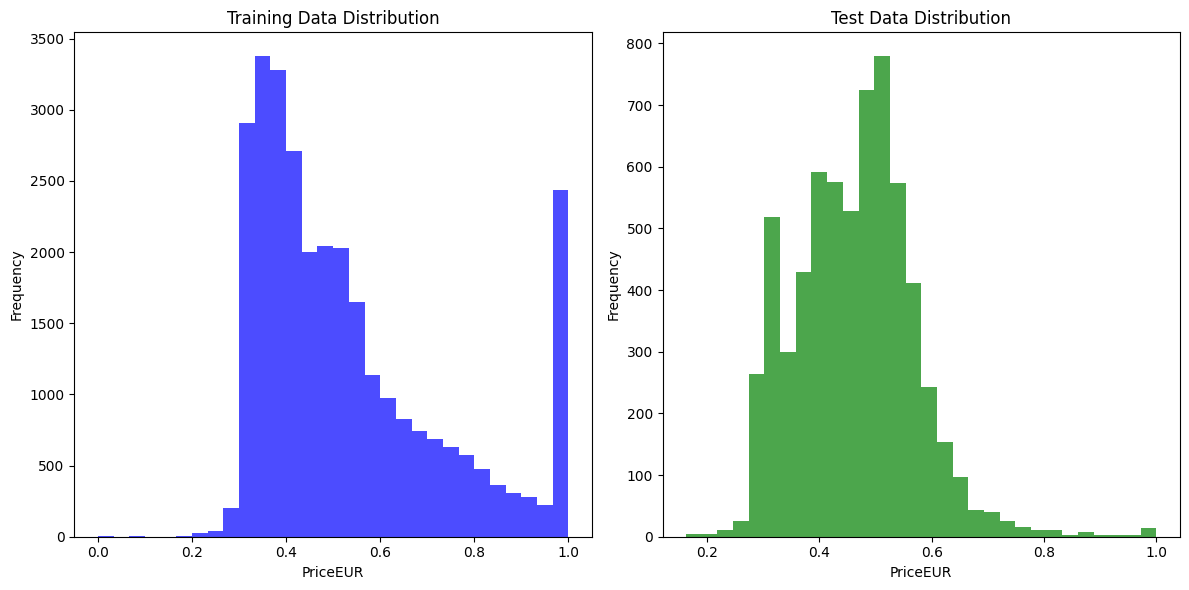

In [9]:
plot_histograms(y_train, y_test)

In [10]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 10) (6411, 10) (6412, 10)
(29920, 1) (6411, 1) (6412, 1)


In [11]:
# Reshape data for LSTM
X_train, X_val, X_test = reshape_data_LSTM(X_train, X_val, X_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 1, 10) (6411, 1, 10) (6412, 1, 10)
(29920, 1) (6411, 1) (6412, 1)


In [ ]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

I0000 00:00:1735486314.202011   19863 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4093 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1735486319.331395   19939 service.cc:148] XLA service 0x559f5b042690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735486319.331464   19939 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-12-29 16:31:59.390921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735486319.886553   19939 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735486322.731182   19939 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 - 13s - 54ms/step - loss: 0.0203 - val_loss: 0.0069
Epoch 2/20


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean Absolute Error: 0.15 EUR


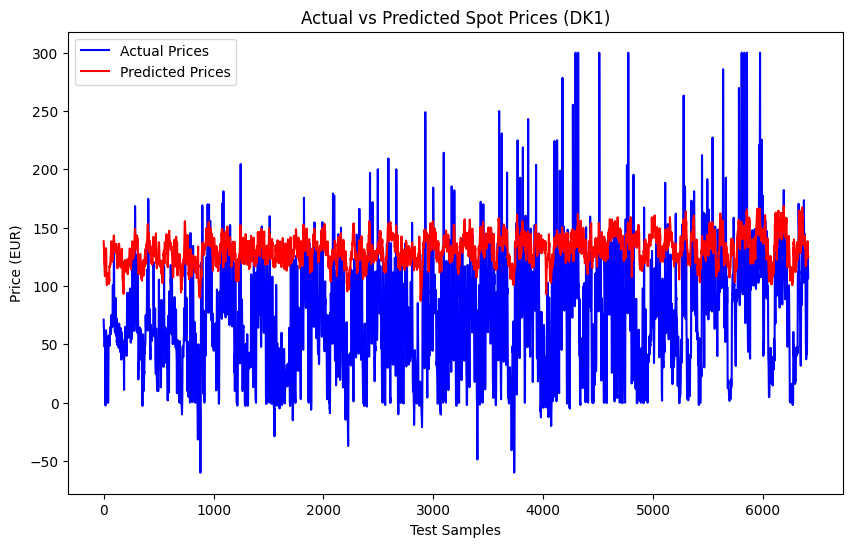

In [ ]:
from lib_descriptive import plot_predictions


predictions = evaluate_model(model, X_test, y_test)
scaled_predictions = scaler_y.inverse_transform(predictions)
scaled_y_test = scaler_y.inverse_transform(y_test)
plot_predictions(scaled_y_test, scaled_predictions)

In [14]:
# Load the model for future predictions
import lib_predictive
import lib_descriptive
import lib_prescriptive
from keras.models import load_model

model = load_model('lstm_model.keras')

201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


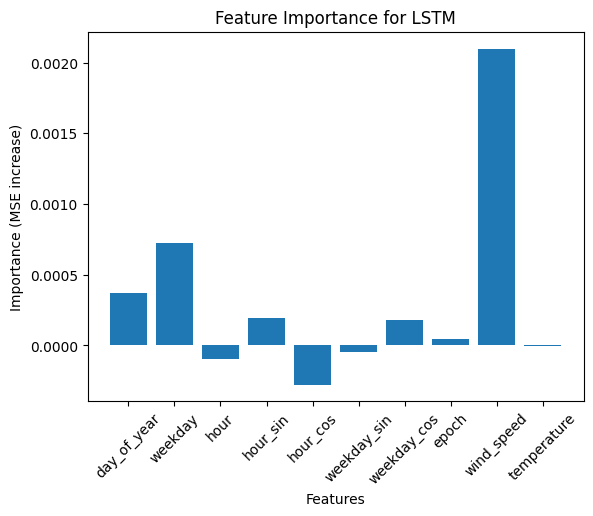

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
baseline_mse = mean_squared_error(y_test, model.predict(X_test))

def permutation_importance(model, X_test, y_test, baseline_mse):
    importances = []
    for feature in range(X_test.shape[2]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, feature])  # Shuffle one feature at a time
        mse = mean_squared_error(y_test, model.predict(X_permuted))
        importances.append(mse - baseline_mse)
    return importances

# Compute feature importances
importances = permutation_importance(model, X_test, y_test, baseline_mse)

# Assuming feature names are available
feature_names = features
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance (MSE increase)')
plt.title('Feature Importance for LSTM')
plt.xticks(rotation=45)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


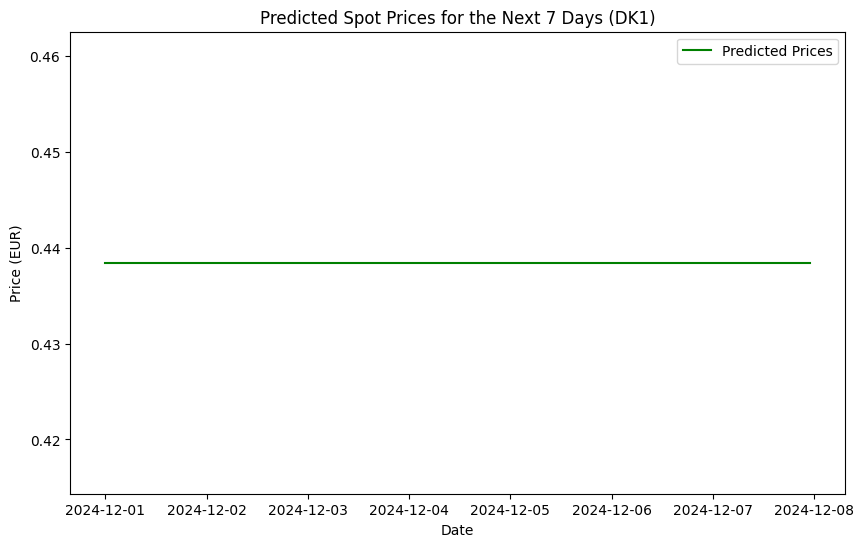

array([[[ 3.36000000e+02,  0.00000000e+00,  1.00000000e+00, ...,
          4.51666667e+00,  0.00000000e+00,  6.43333333e+00]],

       [[ 3.36000000e+02,  2.58819045e-01,  9.65925826e-01, ...,
          3.85000000e+00,  1.00000000e+00,  6.70000000e+00]],

       [[ 3.36000000e+02,  5.00000000e-01,  8.66025404e-01, ...,
          5.85000000e+00,  2.00000000e+00,  6.93333333e+00]],

       ...,

       [[ 3.42000000e+02, -7.07106781e-01,  7.07106781e-01, ...,
          4.96666667e+00,  1.65000000e+02,  5.68333333e+00]],

       [[ 3.42000000e+02, -5.00000000e-01,  8.66025404e-01, ...,
          5.76666667e+00,  1.66000000e+02,  5.70000000e+00]],

       [[ 3.42000000e+02, -2.58819045e-01,  9.65925826e-01, ...,
          7.11666667e+00,  1.67000000e+02,  5.70000000e+00]]])

In [29]:
import lib_descriptive as ld

future_df = predict_future(model, asof)
# rescale priceEUR to original scale
future_df['PriceEUR'] = scaler_y.inverse_transform(future_df['PriceEUR'].values.reshape(-1, 1))


In [17]:
print(future_df)
print(predictions)

[[[ 3.36000000e+02  0.00000000e+00  1.00000000e+00 ...  4.51666667e+00
    0.00000000e+00  6.43333333e+00]]

 [[ 3.36000000e+02  2.58819045e-01  9.65925826e-01 ...  3.85000000e+00
    1.00000000e+00  6.70000000e+00]]

 [[ 3.36000000e+02  5.00000000e-01  8.66025404e-01 ...  5.85000000e+00
    2.00000000e+00  6.93333333e+00]]

 ...

 [[ 3.42000000e+02 -7.07106781e-01  7.07106781e-01 ...  4.96666667e+00
    1.65000000e+02  5.68333333e+00]]

 [[ 3.42000000e+02 -5.00000000e-01  8.66025404e-01 ...  5.76666667e+00
    1.66000000e+02  5.70000000e+00]]

 [[ 3.42000000e+02 -2.58819045e-01  9.65925826e-01 ...  7.11666667e+00
    1.67000000e+02  5.70000000e+00]]]
[[0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.43845055]
 [0.

In [ ]:
future_df

array([[[ 3.36000000e+02,  0.00000000e+00,  1.00000000e+00, ...,
          4.51666667e+00,  0.00000000e+00,  6.43333333e+00]],

       [[ 3.36000000e+02,  2.58819045e-01,  9.65925826e-01, ...,
          3.85000000e+00,  1.00000000e+00,  6.70000000e+00]],

       [[ 3.36000000e+02,  5.00000000e-01,  8.66025404e-01, ...,
          5.85000000e+00,  2.00000000e+00,  6.93333333e+00]],

       ...,

       [[ 3.42000000e+02, -7.07106781e-01,  7.07106781e-01, ...,
          4.96666667e+00,  1.65000000e+02,  5.68333333e+00]],

       [[ 3.42000000e+02, -5.00000000e-01,  8.66025404e-01, ...,
          5.76666667e+00,  1.66000000e+02,  5.70000000e+00]],

       [[ 3.42000000e+02, -2.58819045e-01,  9.65925826e-01, ...,
          7.11666667e+00,  1.67000000e+02,  5.70000000e+00]]])

SyntaxError: invalid syntax (2963548992.py, line 2)